In [6]:
import tensorflow as tf
from config import *
import numpy as np
from utils import aug_utils, bbox_utils, anchor_utils

class DataLoader():
    def __init__(self, dtype=DTYPE, batch_size=GLOBAL_BATCH_SIZE, anchors=ANCHORS, num_anchors=NUM_ANCHORS, num_classes=NUM_CLASSES,
                 image_size=IMAGE_SIZE, strides=STRIDES, positive_iou_threshold=POSITIVE_IOU_THRESHOLD, max_bboxes=MAX_BBOXES):
                 
        self.batch_size = batch_size
        self.num_anchors = num_anchors
        self.len_anchors = len(ANCHORS)
        self.num_classes = num_classes
        self.image_size = image_size
        self.strides = np.array(strides)
        self.scales = image_size//self.strides
        self.anchors = anchor_utils.get_anchors_xywh(anchors, self.strides, self.image_size)
        self.positive_iou_threshold = positive_iou_threshold
        self.max_bboxes = max_bboxes
        self.dtype = dtype
        self._length = {}

    def __call__(self, split, use_tfrecord=True, use_label=False):
        if self.dtype == 'voc':
            from datasets.voc_dataset import Dataset
        elif self.dtype == 'coco':
            from datasets.coco_dataset import Dataset
        elif self.dtype == 'custom':
            from datasets.custom_dataset import Dataset
        elif self.dtype == 'raw':
            from datasets.raw_dataset import Dataset
        dataset = Dataset(split)

        data = dataset.load(use_tfrecord)
        self._length[split] = dataset.length
        data = data.cache()
        
        if split == 'train':
            data = data.shuffle(buffer_size = min(self.length(split) * 3, 200000)) # ram memory limit
            data = data.map(aug_utils.tf_augmentation, num_parallel_calls=-1)
        
        data = data.map(self.tf_preprocessing, num_parallel_calls=-1)
        data = data.padded_batch(self.batch_size, padded_shapes=get_padded_shapes(), padding_values=get_padding_values(), drop_remainder=True)
        
        # data = data.map(lambda x, y: self.py_labels_to_grids(x, y, use_label), num_parallel_calls=-1).prefetch(1)
        data = data.map(lambda x, y: self.tf_labels_to_grids(x, y, use_label), num_parallel_calls=-1).prefetch(1)
        return data
    
    def length(self, split):
        return self._length[split]
    
    def py_labels_to_grids(self, image, labels, use_label=False):
        grids = tf.py_function(self.labels_to_grids, [labels], [tf.float32]*self.len_anchors)
        if use_label:
            return image, *grids, labels
        return image, *grids
    
    @tf.function
    def tf_preprocessing(self, image, labels, width, height):
        image, labels = aug_utils.tf_resize_padding(image, labels, width, height, self.image_size)
        labels = bbox_utils.xyxy_to_xywh(labels, True) 
        labels = tf.concat([labels[..., :4], tf.where(tf.reduce_sum(labels[..., 2:4], -1, keepdims=True)==0, 0., 1.), labels[..., 4:5]], -1)
        return tf.cast(image, tf.float32)/255., labels
    
    @tf.function
    def tf_labels_to_grids(self, image, labels, use_label):
        grids = self.labels_to_grids(labels)
        if use_label:
            return image, *grids, labels
        return image, *grids
        
    @tf.function
    def labels_to_grids(self, labels):
        # return tf.zeros((self.batch_size, 52, 52, 3, 85)), tf.zeros((self.batch_size, 26, 26, 3, 85)), tf.zeros((self.batch_size, 13, 13, 3, 85))
        conf = labels[..., 4:5]
        onehot = tf.where(tf.cast(conf, tf.bool), tf.one_hot(tf.cast(labels[..., 5], dtype=tf.int32), NUM_CLASSES), 0.)
        conf_onehot = tf.concat([conf, onehot], -1)

        grids = []
        c_anchors = [tf.reshape(tf.concat([anchor[..., :2] + 0.5, anchor[..., 2:]], -1), [-1, 4]) for anchor in self.anchors]

        anchors = tf.concat([tf.reshape(c_anchors[i] * self.strides[i], [-1,4]) for i in range(self.len_anchors)], 0)

        ious = bbox_utils.bbox_iou(anchors[:, None], labels[:, None, ..., :4])

        # assign similar label
        best_label_iou = tf.reduce_max(ious, -1)
        best_label_idx = tf.argmax(ious, -1)
        positive_label_mask = tf.where(tf.greater_equal(best_label_iou, self.positive_iou_threshold), 1., 0.)

        maximum_bboxes = tf.concat([tf.tile(anchors[None, :, :2], [self.batch_size, 1, 1]),
                                   tf.gather(labels[..., 2:4], best_label_idx, batch_dims=1)], -1) * positive_label_mask[..., None]
        maximum_conf_onehot = tf.gather(conf_onehot, best_label_idx, batch_dims=1) * positive_label_mask[..., None]

        maximum_labels = tf.concat([maximum_bboxes, maximum_conf_onehot], -1)

        # assign minimum label
        best_anchor_iou = tf.reduce_max(ious, -2)
        best_anchor_mask = tf.cast(tf.logical_and(ious == best_anchor_iou[..., None, :], ious > 0.), tf.float32)

        minimum_labels_without_xy = tf.reduce_max(tf.tile(tf.concat([labels[..., 2:4], conf_onehot], -1)[:, None], [1, len(anchors), 1, 1]) * best_anchor_mask[..., None], -2)
        minimum_labels = tf.concat([tf.tile(anchors[None, :, :2], [self.batch_size, 1, 1]), minimum_labels_without_xy], -1)

        # join minimum, maximum label
        minimum_mask = tf.cast(tf.reduce_max(best_anchor_mask, -1, keepdims=True), tf.bool)
        assign_labels = tf.where(minimum_mask, minimum_labels, maximum_labels)

        for i in range(self.len_anchors):
            scale = self.scales[i]
            start = 0 if i==0 else tf.reduce_sum((self.image_size//self.strides[:i])**2 * self.len_anchors)
            end = start + (scale)**2 * self.len_anchors
            grids += [tf.reshape(assign_labels[:, start:end], [self.batch_size, scale, scale, self.len_anchors, -1])]

        return grids
    
def get_padded_shapes():
    return [None, None, None], [MAX_BBOXES, None]

def get_padding_values():
    return tf.constant(0, tf.float32), tf.constant(0, tf.float32)

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def draw_box(image, bbox, xywh=True, color=(0,0,0), line_size=1):
    if xywh:
        p1 = (bbox[:2] - 0.5 * bbox[2:4]).astype(np.int32).tolist()
        p2 = (bbox[:2] + 0.5 * bbox[2:4]).astype(np.int32).tolist()
    else:
        p1 = bbox[:2].astype(np.int32).tolist()
        p2 = bbox[2:4].astype(np.int32).tolist()

    cv2.rectangle(image, p1, p2, color, line_size)

def draw_text(image, bbox, label, xywh=True, color=(0,0,0), labels=LABELS):
    if xywh:
        p = (bbox[:2] - 0.5 * bbox[2:4]).astype(np.int32)
    else:
        p = bbox[:2].astype(np.int32)

    text = LABELS[label.astype(np.int32)]
    cv2.putText(image, text, [p[0]+5, p[1]+15], cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, color, 1)

In [9]:
from utils import data_utils
dataloader = DataLoader()
data = dataloader('val', use_label=True)
d = next(iter(data))
images, s_grids, m_grids, l_grids, labels = d

Dataset: coco val
./data/coco/val.tfrecord is exist


2023-05-31 04:24:57.234010: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


49, 22, 0
[396. 180.  41.  74.] 1.0 23
49, 23, 0
[396. 188.  41.  74.] 1.0 23
49, 24, 0
[396. 196.  41.  74.] 1.0 23
49, 25, 0
[396. 204.  41.  74.] 1.0 23
49, 26, 0
[396. 212.  41.  74.] 1.0 23
49, 27, 0
[396. 220.  41.  74.] 1.0 23
49, 28, 0
[396. 228.  41.  74.] 1.0 23
49, 29, 0
[396. 236.  41.  74.] 1.0 23
49, 30, 0
[396. 244.  41.  74.] 1.0 23
49, 31, 0
[396. 252.  41.  74.] 1.0 23
49, 32, 0
[396. 260.  41.  74.] 1.0 23
49, 33, 0
[396. 268.  41.  74.] 1.0 23
49, 34, 0
[396. 276.  41.  74.] 1.0 23


5, 5, 2
[176. 176. 372. 271.] 1.0 23
4, 6, 2
[144. 208. 372. 271.] 1.0 23
5, 6, 2
[176. 208. 372. 271.] 1.0 23
6, 6, 2
[208. 208. 372. 271.] 1.0 23
7, 6, 2
[240. 208. 372. 271.] 1.0 23
5, 7, 2
[176. 240. 372. 271.] 1.0 23
6, 7, 2
[208. 240. 372. 271.] 1.0 23


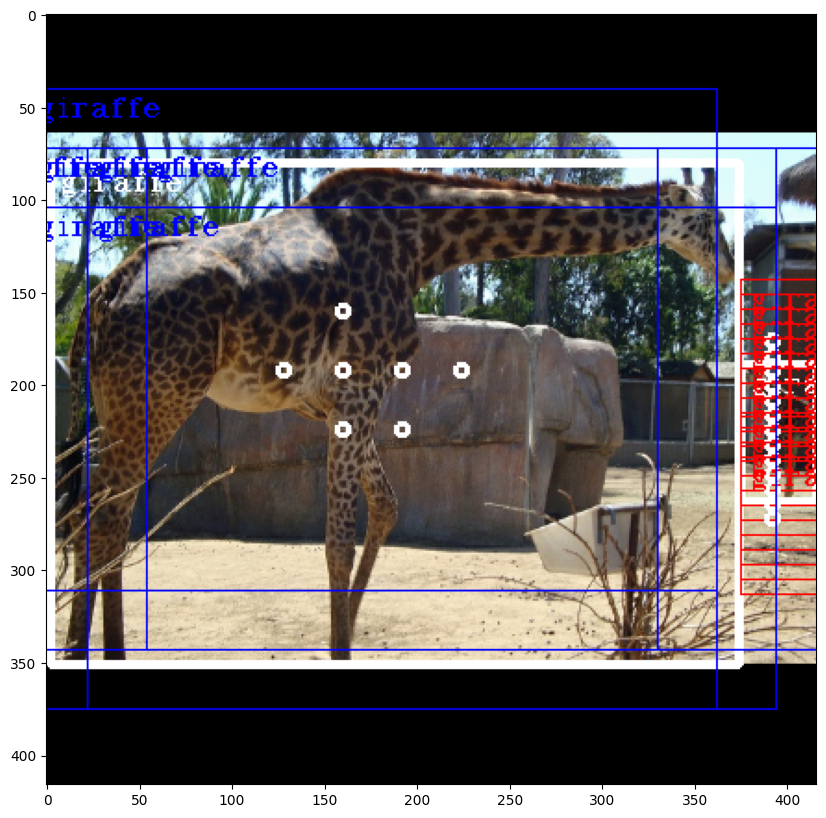

In [10]:
plt.figure(figsize=(10,10))

for i, (image, s_grid, m_grid, l_grid, label) in enumerate(zip(images, s_grids, m_grids, l_grids, labels)):
    if i==0:
        image = (image.numpy()*255).astype(np.uint8)
        for gt in label.numpy():
            bbox = gt[:4]
            conf = gt[4]
            prob = gt[5]
            if conf ==0:
                continue
            draw_box(image, bbox, True, (255,255,255), 3)
            draw_text(image, bbox, prob, True, (255,255,255))
        
        if True:
            size = 8
            for y, pred_y in enumerate(s_grid.numpy()):
                for x, pred_x in enumerate(pred_y):
                    for a, pred in enumerate(pred_x):
                        bbox = pred[:4]
                        conf = pred[4]
                        prob = np.argmax(pred[5:])
                        if conf == 0:
                            continue
                        draw_box(image, bbox, color=(255, 0, 0))
                        draw_text(image, bbox, prob, color=(255, 0, 0))
                        cv2.circle(image, [x*size, y*size], 3, (255,255,255), 2)
                        print(f'{x}, {y}, {a}')
                        print(bbox, conf, prob)
            print()
        
        if True:
            size = 16
            for y, pred_y in enumerate(m_grid.numpy()):
                for x, pred_x in enumerate(pred_y):
                    for a, pred in enumerate(pred_x):
                        bbox = pred[:4]
                        conf = pred[4]
                        prob = np.argmax(pred[5:])
                        if conf == 0:
                            continue
                        draw_box(image, bbox, color=(0, 255, 0))
                        draw_text(image, bbox, prob, color=(0, 255, 0))
                        cv2.circle(image, [x*size, y*size], 3, (255,255,255), 2)
                        print(f'{x}, {y}, {a}')
                        print(bbox, conf, prob)
            print()

        if True:
            size = 32
            for y, pred_y in enumerate(l_grid.numpy()):
                for x, pred_x in enumerate(pred_y):
                    for a, pred in enumerate(pred_x):
                        bbox = pred[:4]
                        conf = pred[4]
                        prob = np.argmax(pred[5:])
                        if conf == 0:
                            continue
                        draw_box(image, bbox, color=(0, 0, 255))
                        draw_text(image, bbox, prob, color=(0, 0, 255))
                        cv2.circle(image, [x*size, y*size], 3, (255,255,255), 2)
                        print(f'{x}, {y}, {a}')
                        print(bbox, conf, prob)
        plt.imshow(image)

plt.show()
#[12, 12, 1], [205.5 201.5 383.  103. ]

In [6]:
labels[1]

<tf.Tensor: shape=(100, 6), dtype=float32, numpy=
array([[287.5, 208.5, 255. , 267. ,   1. ,   0. ],
       [114. , 252. , 176. , 150. ,   1. ,  63. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0

In [1]:
import numpy as np
from utils import bbox_utils
import tensorflow as tf

In [5]:
a = np.array([[10, 10, 100, 100]], np.float32)
b = np.array([[30,30, 30, 30]], np.float32)
bbox_utils.bbox_iou(a, b, iou_type='diou')

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.05], dtype=float32)>

In [1]:
import tensorflow as tf
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

In [3]:
gpus = tf.config.list_physical_devices('GPU')


In [4]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "LOGICAL GPUs")
    except RuntimeError as error:
        print(error)

2 Physical GPUs, 2 LOGICAL GPUs


2023-06-05 07:16:25.643587: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 07:16:27.050474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23216 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2023-06-05 07:16:27.051323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 23216 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0
